In [13]:
from SafeTransformer import SafeTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import random
import matplotlib.pyplot as plt
from math import sqrt

In [8]:
apartments = pd.read_csv('apartments.csv', index_col=0)

In [9]:
X_ap = apartments.drop(columns='m2.price')
y = apartments['m2.price']

In [10]:
X = X_ap.copy()
colnames = list(X)
for idx, name in enumerate(colnames):
    if str(X.loc[:, name].dtype) in ['category', 'object']:
        dummies = pd.get_dummies(X.loc[:, name], prefix=name, drop_first=True)
        dummy_index  = X.columns.get_loc(name)
        X = pd.concat([X.iloc[:,range(dummy_index)], dummies, X.iloc[:, range(dummy_index+1, len(X.columns))]], axis=1)

In [11]:
X_train, X_test, X_lin_train, X_lin_test, y_train, y_test = train_test_split(X_ap, X, y, random_state =123)

# SAFE

In [14]:
linear_model = LinearRegression()

linear_model = linear_model.fit(X_lin_train, y_train)
standard_predictions = linear_model.predict(X_lin_test)
standard_predictions_error = sqrt(mean_squared_error(y_test, standard_predictions))
standard_predictions_error

275.1055139864287

In [18]:
surrogate_model = GradientBoostingRegressor(random_state=123)
surrogate_model = surrogate_model.fit(X_lin_train, y_train)
surrogate_model_predictions = surrogate_model.predict(X_lin_test)
surrogate_model_predictions_error = sqrt(mean_squared_error(y_test, surrogate_model_predictions))
surrogate_model_predictions_error

103.07993297411586

In [19]:
pens = np.linspace(0.01, 10, 25)
best_score = float('Inf')
best_pen = 0
errors = [] 

for pen in pens:
    surrogate_model = GradientBoostingRegressor(n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        loss='huber', random_state = 123)
    linear_model_simple = LinearRegression()
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)
    pipe = Pipeline(steps=[('safe', safe_transformer), ('linear', linear_model_simple)])
    pipe = pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    error = sqrt(mean_squared_error(y_test, predictions))
    errors.append(error)
    print([pen, error])
    if error < best_score:
        best_score = error
        best_pen = pen

[0.01, 35.0207002500316]
[0.42625, 34.944870475635504]
[0.8425, 34.83976683925763]
[1.25875, 34.96477780419431]
[1.675, 34.976481873429755]
[2.0912499999999996, 34.697890508870316]
[2.5075, 34.81483632242456]
[2.92375, 34.68126789000151]
[3.34, 34.54494526571628]
[3.7562499999999996, 34.60086291158496]
[4.172499999999999, 34.16900247232948]
[4.58875, 34.130777260949024]
[5.005, 34.12477185636778]
[5.42125, 34.15863539570437]
[5.8375, 34.478860904681284]
[6.25375, 34.478860904681284]
[6.67, 34.49791786363306]
[7.08625, 34.619602188813076]
[7.5024999999999995, 34.69784337839157]
[7.91875, 34.728299598553]
[8.334999999999999, 34.45619503920495]
[8.75125, 34.524021292900734]
[9.1675, 34.548118466914]
[9.58375, 34.57192095831231]
[10.0, 34.57192095831231]


In [58]:
best_score

1164.5000542491505

# Plot

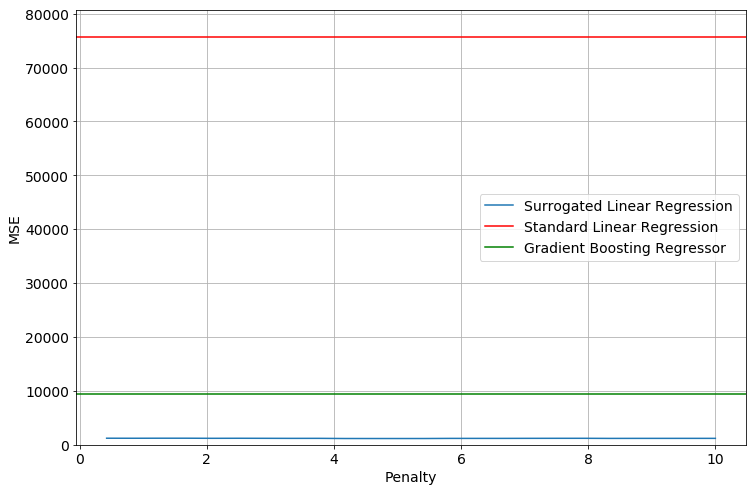

In [59]:
standard_error = mean_squared_error(y_test, standard_predictions)
xgb_error = mean_squared_error(y_test, surrogate_model_predictions)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})
plt.plot(pens[1:], errors[1:], label='Surrogated Linear Regression')
plt.xlabel('Penalty')
plt.ylabel('MSE')
plt.grid(True)
plt.axhline(standard_error, color='r', label='Standard Linear Regression')
plt.axhline(xgb_error, color='g', label='Gradient Boosting Regressor')
plt.ylim((0, max(max(errors[1:])+5000, standard_error+5000)))
plt.legend()
plt.show()

In [20]:
f, axis = plot_partial_dependence(surrogate_model, X, [0],
                                   figsize=[12, 8],
                                 line_kw = {"linewidth": 5}) 
plt.axvline(-2.28,  linewidth=3.0)
plt.axvline(2.49,  linewidth=3.0)
# plt.ylim(, 1.43)
plt.xlim(min(X["X1"]), max(X["X1"]))
plt.xlabel('X1')
# plt.ylabel('Average Response')
plt.grid(True)

# f.savefig("boston_PDP_ZN.pdf", bbox_inches='tight')

NameError: name 'plot_partial_dependence' is not defined